# Topic-based Sentiment Analysis with a Real Dataset


---
















Semeval 2017 task4(subtask B) provides a tweet text dataset with topics.
Given a tweet and a topic, we need to classify the sentiment conveyed towards that topic on a  two-point scale:   POSITIVE vs. NEGATIVE.
Although it is still a binary classification task, this classifier needs to analyze the text and its topic. 

We are going to use Keras Sequential API. The Sequential API allows you to make models layer-by-layer. 

In [1]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer 

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model
from keras.utils import plot_model


### Downloading and preprocessing data

The data is not balanced: the numbers of positive and negative instances are not equal, in either training or test set.


In [2]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016devtest-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016dev-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2016train-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015test-BD.tsv')
downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/downloaded/twitter-2015train-BD.tsv')

downloadfile('https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_BD/gold/SemEval2017-task4-test.subtask-BD.english.txt')

with open('twitter-2016dev-BD.tsv', 'r',encoding="utf-8") as f:
  dev_original = [l.strip().split('\t') for l in f.readlines()]
with open('SemEval2017-task4-test.subtask-BD.english.txt', 'r',encoding="utf-8") as f:
  test_original = [l.strip().split('\t') for l in f.readlines()]
train_original = []
with open('twitter-2016train-BD.tsv', 'r',encoding="utf-8") as f:
  train_original = [l.strip().split('\t') for l in f.readlines()]
with open('twitter-2016test-BD.tsv', 'r',encoding="utf-8") as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2016devtest-BD.tsv', 'r',encoding="utf-8") as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines()])
with open('twitter-2015test-BD.tsv', 'r',encoding="utf-8") as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])
with open('twitter-2015train-BD.tsv', 'r',encoding="utf-8") as f:
  train_original.extend([l.strip().split('\t') for l in f.readlines() if l.strip().split('\t')[2] in ['negative','positive']])

print("Training entries: {}".format(len(train_original)))
print("Development entries: {}".format(len(dev_original)))
print("Testing entries: {}".format(len(test_original)))

Training entries: 17639
Development entries: 1325
Testing entries: 6185


We now can start playing around with the data, let’s first see some examples:

In [3]:
print("ID \t TOPIC \t LABLE \t TWEET_TEXT")
print(train_original[0])
print(train_original[1])
print(train_original[2])
print(train_original[3])
print(train_original[4])

ID 	 TOPIC 	 LABLE 	 TWEET_TEXT
['628949369883000832', '@microsoft', 'negative', "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."]
['628976607420645377', '@microsoft', 'negative', "@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!"]
['629023169169518592', '@microsoft', 'negative', "I may be ignorant on this issue but... should we celebrate @Microsoft's parental leave changes? Doesn't the gender divide suggest... (1/2)"]
['629179223232479232', '@microsoft', 'negative', 'Thanks to @microsoft, I just may be switching over to @apple.']
['629226490152914944', '@microsoft', 'positive', 'Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft']


Build a vocabulary based on the training dataset. 

In [4]:
#Create dictionary
voc = []
from keras.preprocessing.text import text_to_word_sequence
for example in train_original:
  topic_tokens = text_to_word_sequence(example[1])
  text_tokens = text_to_word_sequence(example[3])
  voc.extend(topic_tokens)
  voc.extend(text_tokens)
voc = set(voc)
print(len(voc))

word_index = dict()
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<EOS>"] = 3
for w in voc:
  word_index[w] = len(word_index)
print(len(word_index))

32571
32575


In [5]:
word_index["<UNK>"]

2

In [6]:
def preprocess_text(corpus):
    '''
    Write code for preprocessing corpus here
    '''
    processedCorpus = []
    for line in corpus:

        Text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", line) # Separating words and special charaters from words that comes after the word
        Text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", Text) # Separating words and special charaters from words that comes before the word
        Text = re.sub(r"(//d)(\w)", r"\1 \2", Text) # Removing digits
        tokenizer = RegexpTokenizer(r'\w+')         # Initialize tokenizer
        tokens = tokenizer.tokenize(Text)           # Tokenize the words
        tokens = [t.lower() for t in tokens]        # Lowercased the tokens
        #stop = set(stopwords.words('english'))      # Stop contains all the stopwords in the english vocab
        #tokens = [t for t in tokens if t not in stop] # Removes all stopwords
        processedCorpus.append(tokens)          # Append tokens to local list

    #print(len(processedCorpus))
    return processedCorpus   

def wordindex(corpus):              #function converting word to index 
    index = []
    for word in corpus:
        inner = []
        for w in word:
            try:
                inner.append(word_index[w])  # Finds the index to the word and appends it to inner list
            except KeyError:
                inner.append(word_index["<UNK>"])            
        index.append(inner)     # Once every token in the list is transformed, its appended to sents_as_ids list
    return index
    

According to the word_index and the tokenizer function (text_to_word_sequence), we can convert the tweet text and topic words to word tokens and integers separately:


In [8]:
# Please write your code to generate the following data

##### your code goes here:

x_dev_tweetb4tokenize = []
x_dev_topicb4tokenize = []
x_test_tweetb4tokenize = []
x_test_topicb4tokenize = []
x_train_tweetb4tokenize = []
x_train_topicb4tokenize = []

for w in dev_original:                          #Extracts the tweet and topics from dev set
    x_dev_tweetb4tokenize.append(w[3])
    x_dev_topicb4tokenize.append(w[1])

for w in test_original:                         #Extracts the tweet and topics from test set
    x_test_tweetb4tokenize.append(w[3])
    x_test_topicb4tokenize.append(w[1])

for w in train_original:                        #Extracts the tweet and topics from train set
    x_train_tweetb4tokenize.append(w[3])
    x_train_topicb4tokenize.append(w[1])

    
x_dev_tweet = preprocess_text(x_dev_tweetb4tokenize)     # preprocess the list and tokenize
x_dev_topic = preprocess_text(x_dev_topicb4tokenize)
x_dev_tweet_int = wordindex(x_dev_tweet)                 # convert the tweets into its index representation
x_dev_topic_int = wordindex(x_dev_topic)                 # convert the topics into its index representation
 
x_test_tweet = preprocess_text(x_test_tweetb4tokenize)   # preprocess the list and tokenize
x_test_topic = preprocess_text(x_test_topicb4tokenize)   # preprocess the list and tokenize
x_test_tweet_int = wordindex(x_test_tweet)               # convert the tweets into its index representation
x_test_topic_int = wordindex(x_test_topic)               # convert the topics into its index representation

x_train_tweet = preprocess_text(x_train_tweetb4tokenize)   # preprocess the list and tokenize
x_train_topic = preprocess_text(x_train_topicb4tokenize)   # preprocess the list and tokenize
x_train_tweet_int = wordindex(x_train_tweet)               # convert the tweets into its index representation
x_train_topic_int = wordindex(x_train_topic)               # convert the topics into its index representation



# If use the previous word_index, you can get a print result like:
assert len(x_train_topic) == len(train_original)
assert len(x_train_topic) == len(x_train_topic_int)
assert len(x_test_topic) == len(test_original)
assert len(x_test_topic) == len(x_test_topic_int)
print("x_dev_tweet[0]:")
print(x_dev_tweet[0])
print("x_dev_topic[0]:")
print(x_dev_topic[0])
print("x_dev_tweet_int[0]:")
print(x_dev_tweet_int[0])
print("x_dev_topic_int[0]:")
print(x_dev_topic_int[0])

x_dev_tweet[0]:
['jay', 'z', 'joins', 'instagram', 'with', 'nostalgic', 'tribute', 'to', 'michael', 'jackson', 'jay', 'z', 'apparently', 'joined', 'instagram', 'on', 'saturday', 'and', 'http', 't', 'co', 'qj9i4ecvxy']
x_dev_topic[0]:
['michael', 'jackson']
x_dev_tweet_int[0]:
[12934, 23500, 10914, 27456, 17625, 30206, 28205, 1218, 8883, 25335, 12934, 23500, 23634, 10509, 27456, 23803, 30779, 2998, 6291, 19340, 7903, 2]
x_dev_topic_int[0]:
[8883, 25335]


In [9]:
# x_dev_tweet[0]:
# ['jay', 'z', 'joins', 'instagram', 'with', 'nostalgic', 'tribute', 'to', 'michael', 'jackson', 'jay', 'z', 'apparently', 'joined', 'instagram', 'on', 'saturday', 'and', 'http', 't', 'co', 'qj9i4ecvxy']
# x_dev_topic[0]:
# ['michael', 'jackson']
# x_dev_tweet_int[0]:
# [13089, 2308, 13715, 18119, 6500, 22489, 20887, 6811, 15614, 10701, 13089, 2308, 27813, 31851, 18119, 21494, 21376, 27720, 15232, 29316, 17386, 2]
# x_dev_topic_int[0]:
# [15614, 10701]

We use 1 to represent "positive" and 0 for "negative" and generate the "y" data similar to previous labs.

In [10]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append(0)
    else:
      y.append(1)
  return y
  
y_train = label2int(train_original)
y_dev = label2int(dev_original)
y_test = label2int(test_original)

y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

0
0
0
0
1


In [121]:
# Please write your code to combine the x_*_tweet and x_*_topic into the following varibles
start = ["<START>"]

# Tips: 
# 1) We can use the special token <START> to concatenate the tweets and topics.
# 2) After combine them, do not foget to pad the sequences.


##### your code goes here:
x_train = []
x_dev = []
x_test = []

for w in range (len(x_dev_tweet)):                           # Combining the tweets and the topics in the dev set
    combined = x_dev_topic[w] + start + x_dev_tweet[w]       # Adds <START> in between
    x_dev.append(combined)

for w in range (len(x_train_tweet)):                         # Combining the tweets and the topics in the train set
    combined = x_train_topic[w] + start + x_train_tweet[w]   # Adds <START> in between
    x_train.append(combined)
    
for w in range (len(x_test_tweet)):                          # Combining the tweets and the topics in the test set
    combined = x_test_topic[w] + start + x_test_tweet[w]     # Adds <START> in between
    x_test.append(combined)
    
x_train_int = wordindex(x_train)                             # convert the combined train lists into its index representation
x_dev_int = wordindex(x_dev)                                 # convert the combined dev lists into its index representation
x_test_int = wordindex(x_test)                               # convert the combined test lists into its index representation

x_train_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_train_int,         # pads the data, length = 128
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))
x_dev_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_dev_int,             # pads the data, length = 128
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))

x_test_pad = np.array(keras.preprocessing.sequence.pad_sequences(x_test_int,           # pads the data, length = 128
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train[0])
print(x_train_int[0])
print("After paded:")
print(x_train_pad[0])

Before paded:
['microsoft', '<START>', 'dear', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', 'but', 'no', 'lync', 'update', 'c', 'mon']
[26784, 1, 20356, 26784, 6786, 17780, 27401, 4257, 21176, 27164, 2998, 16146, 3417, 26121, 3842, 22660, 11483, 14098]
After paded:
[26784     1 20356 26784  6786 17780 27401  4257 21176 27164  2998 16146
  3417 26121  3842 22660 11483 14098     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0   

#Model 1: Previous models without pre-trained word embeddings

## Model 1-1: Neural bag of words without pre-trained word embeddings

Now we use the model2 in lab4 to deal with the SEMEVAL2017 task4 subtask B. We have preprocess the data to fit in this model in previous steps.

In [13]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


In [14]:
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

VOCAB_SIZE = 32575
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE = 100

Input = Input((128,), dtype='int32')
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, mask_zero=True)(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model = Model(inputs=[Input], outputs=[Output])  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 100)          3257500   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,259,133
Trainable params: 3,259,133
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Train the model
history = model.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 3s 74ms/step - loss: 0.5701 - accuracy: 0.7847 - val_loss: 0.5681 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 2s 47ms/step - loss: 0.5085 - accuracy: 0.7929 - val_loss: 0.5597 - val_accuracy: 0.7442
Epoch 3/30
35/35 [==============================] - 2s 48ms/step - loss: 0.4716 - accuracy: 0.7952 - val_loss: 0.5433 - val_accuracy: 0.7442
Epoch 4/30
35/35 [==============================] - 2s 48ms/step - loss: 0.4397 - accuracy: 0.7936 - val_loss: 0.5123 - val_accuracy: 0.7442
Epoch 5/30
35/35 [==============================] - 2s 47ms/step - loss: 0.3988 - accuracy: 0.7933 - val_loss: 0.4826 - val_accuracy: 0.7509
Epoch 6/30
35/35 [==============================] - 2s 49ms/step - loss: 0.3493 - accuracy: 0.8353 - val_loss: 0.4614 - val_accuracy: 0.7653
Epoch 7/30
35/35 [==============================] - 2s 48ms/step - loss: 0.3133 - accuracy: 0.8702 - val_loss: 0.4487 - val_accuracy: 0.7698
Epoch 8/30
35

In [16]:
results = model.evaluate(x_test_pad, y_test)
print(results)

194/194 [==============================] - 0s 1ms/step - loss: 0.9089 - accuracy: 0.7032
[0.9089480638504028, 0.7031527757644653]


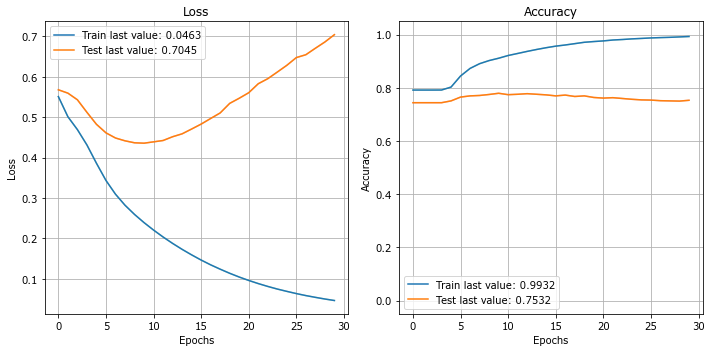

In [17]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

The accuracy of the lab4 model2 in this task is around 78%. 

##  Model 1-2: CNN or LSTM without pre-trained word embeddings

Please try one more model (CNN or LSTM) without pre-trained word embeddings in here:

In [18]:
# Try CNN or LSTM without pre-trained word embeddings in here:

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding, MaxPooling1D
from keras.models import Model
from keras.models import Sequential

# your code goes here
VOCAB_SIZE = 32575
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE = 100


Input = Input((128,), dtype='int32')
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, mask_zero=True)(Input)
conv1d = Conv1D(filters = 128,kernel_size= 5, activation='relu')(Embedding)
global_max_pooling1d = GlobalAveragePooling1D()(conv1d)
Hidden = Dense(10, activation='relu')(global_max_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden)
model1 = Model(inputs=[Input], outputs=[Output])
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model1.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 100)          3257500   
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 128)          64128     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,322,929
Trainable params: 3,322,929
Non-trainable params: 0
_________________________________________________

In [19]:
history = model1.fit(x_train_pad,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 5s 141ms/step - loss: 0.6136 - accuracy: 0.7660 - val_loss: 0.5685 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 5s 135ms/step - loss: 0.4993 - accuracy: 0.7937 - val_loss: 0.5466 - val_accuracy: 0.7442
Epoch 3/30
35/35 [==============================] - 5s 135ms/step - loss: 0.4458 - accuracy: 0.7935 - val_loss: 0.4595 - val_accuracy: 0.7442
Epoch 4/30
35/35 [==============================] - 5s 132ms/step - loss: 0.3362 - accuracy: 0.7897 - val_loss: 0.4372 - val_accuracy: 0.7442
Epoch 5/30
35/35 [==============================] - 5s 132ms/step - loss: 0.2858 - accuracy: 0.8651 - val_loss: 0.4632 - val_accuracy: 0.7743
Epoch 6/30
35/35 [==============================] - 5s 132ms/step - loss: 0.2507 - accuracy: 0.9201 - val_loss: 0.4762 - val_accuracy: 0.7819
Epoch 7/30
35/35 [==============================] - 5s 135ms/step - loss: 0.2195 - accuracy: 0.9379 - val_loss: 0.4814 - val_accuracy: 0.7819
Epoch 

In [61]:
results = model1.evaluate(x_test_pad, y_test)
print(results)

194/194 [==============================] - 1s 3ms/step - loss: 2.1384 - accuracy: 0.6438
[2.1384477615356445, 0.6438156962394714]


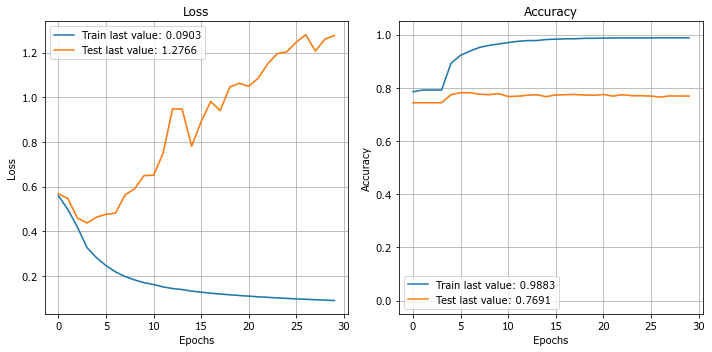

In [62]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [82]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r', encoding="utf8") as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [83]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [84]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


We freeze the weights. To create the model: 

In [85]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)



Size of Embedding:  300


In [33]:
from keras.layers import Embedding
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

### Convert the data to GLOVE word index

The index in our vocabulary is different from that in GLOVE. For example, the word "you" corresponds to 394475 in GLOVE, while it corresponds to another index in our vocabulary. Thus we can not directly use the index data in the last section. We convert them from text tokens to GLOVE word index.

In [48]:
print(wordToIndex["you"])
print(indexToWord[394475])
print(word_index["you"])

wordToIndex["<PAD>"] = 0
wordToIndex["<START>"] = 1
wordToIndex["<UNK>"] = 2  
wordToIndex["<EOS>"] = 3

394475
you
11963


In [49]:
def wordindexGlove(corpus):  # Function to convert words to its index representation based of GLOVE
    index = []
    for word in corpus:
        inner = []
        for w in word:
            try:
                inner.append(wordToIndex[w])  # Finds the index to the word and appends it to inner list
            except KeyError:
                inner.append(wordToIndex["<UNK>"])            
        index.append(inner)     # Once every token in the list is transformed, its appended to sents_as_ids list
    return index

In [50]:
# Please write your code to generate the following data


##### your code goes here:

#dev
x_dev_tweet = preprocess_text(x_dev_tweetb4tokenize)        # preprocess the list and tokenize
x_dev_topic = preprocess_text(x_dev_topicb4tokenize)        # preprocess the list and tokenize
x_dev_tweet_glove = wordindexGlove(x_dev_tweet)             # convert the tweets into its index representation
x_dev_topic_glove = wordindexGlove(x_dev_topic)             # convert the topics into its index representation

#test
x_test_tweet = preprocess_text(x_test_tweetb4tokenize)      # preprocess the list and tokenize
x_test_topic = preprocess_text(x_test_topicb4tokenize)      # preprocess the list and tokenize
x_test_tweet_glove = wordindexGlove(x_test_tweet)           # convert the tweets into its index representation
x_test_topic_glove = wordindexGlove(x_test_topic)           # convert the topics into its index representation

#train
x_train_tweet = preprocess_text(x_train_tweetb4tokenize)    # preprocess the list and tokenize
x_train_topic = preprocess_text(x_train_topicb4tokenize)    # preprocess the list and tokenize
x_train_tweet_glove = wordindexGlove(x_train_tweet)         # convert the tweets into its index representation
x_train_topic_glove = wordindexGlove(x_train_topic)         # convert the topics into its index representation



# You should get a print result like:
assert len(x_train_tweet_glove) == len(train_original)
assert len(x_train_topic_glove) == len(x_train_topic_int)
assert len(x_test_tweet_glove) == len(test_original)
assert len(x_test_topic_glove) == len(x_test_topic_int)
print("x_dev_tweet_glove[0]:")
print(x_dev_tweet_glove[0])
print("x_dev_topic_glove[0]:")
print(x_dev_topic_glove[0])

x_dev_tweet_glove[0]:
[196237, 395262, 198486, 190716, 388711, 264529, 365027, 360915, 242891, 194733, 196237, 395262, 57698, 198478, 190716, 269798, 319134, 54718, 182915, 350784, 103530, 2]
x_dev_topic_glove[0]:
[242891, 194733]


As before, we concatenate the tweets and topics for fitting in the previous model. Let us do it again for GLOVE version variables.

In [60]:
# Please write your code to combine the x_*_tweet_glove and x_*_topic_glove into the following varibles
start = ["<START>"]

# Tips: 
# 1) There is no <START> token in GLOVE. Here we can use integer 1 to concatenate.
# 2) After combine them, do not foget to pad the sequences.


##### your code goes here:
x_train_glove_combined = []
x_dev_glove_combined = []
x_test_glove_combined = []

for w in range (len(x_dev_tweet_glove)):                      # Combining the tweets and the topics in the dev set
    combined = x_dev_topic[w] + start + x_dev_tweet[w]        # Adds <START> in between
    x_dev_glove_combined.append(combined)

for w in range (len(x_train_tweet_glove)):                    # Combining the tweets and the topics in the train set
    combined = x_train_topic[w] + start + x_train_tweet[w]    # Adds <START> in between
    x_train_glove_combined.append(combined)
    
for w in range (len(x_test_tweet_glove)):                     # Combining the tweets and the topics in the test set
    combined = x_test_topic[w] + start + x_test_tweet[w]      # Adds <START> in between
    x_test_glove_combined.append(combined)
    
x_train_glove = wordindexGlove(x_train_glove)                 # convert the combined train lists into its index representation
x_dev_glove = wordindexGlove(x_dev_glove)                     # convert the combined dev lists into its index representation
x_test_glove = wordindexGlove(x_test_glove)                   # convert the combined test lists into its index representation


x_train_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_train_glove,       # pads the data, length = 128
                                                        value=wordToIndex["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))
x_dev_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_dev_glove,           # pads the data, length = 128
                                                        value=wordToIndex["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))

x_test_pad_glove = np.array(keras.preprocessing.sequence.pad_sequences(x_test_glove,         # pads the data, length = 128
                                                        value=wordToIndex["<PAD>"],
                                                        padding='post',
                                                        maxlen=128))

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function, such as: x_train_pad = np.array(x_train_pad)
# Only pad the *_int varibles
print("Before paded:")
print(x_train_glove[0])
print("After paded:")
print(x_train_pad_glove[0])

Before paded:
[243317, 1, 118309, 243317, 357266, 2, 151349, 229153, 192973, 166369, 54718, 51582, 87775, 262350, 228306, 373375, 88542, 248286]
After paded:
[243317      1 118309 243317 357266      2 151349 229153 192973 166369
  54718  51582  87775 262350 228306 373375  88542 248286      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0     

## Model 2-1: Neural bag of words using pre-trained word embeddings

We use model3-1 in lab4 to deal with this task.

In [63]:
# your code goes here
# Tips: Do not misuse the training data

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Model
from keras.models import Sequential

Input = Input((128,), dtype='int32')
Embedding = embeddingLayer(Input)
global_average_pooling1d = GlobalAveragePooling1D()(Embedding)
Hidden_1 = Dense(16,activation='sigmoid')(global_average_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model3 = Model(inputs=[Input], outputs=[Output])  

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model3.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
global_average_pooling1d_2 ( (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
_________________________________________________________________


In [64]:
history = model3.fit(x_train_pad_glove,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 27ms/step - loss: 0.6180 - accuracy: 0.7877 - val_loss: 0.5842 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 1s 22ms/step - loss: 0.5401 - accuracy: 0.7887 - val_loss: 0.5691 - val_accuracy: 0.7442
Epoch 3/30
35/35 [==============================] - 1s 22ms/step - loss: 0.5164 - accuracy: 0.7888 - val_loss: 0.5693 - val_accuracy: 0.7442
Epoch 4/30
35/35 [==============================] - 1s 22ms/step - loss: 0.5034 - accuracy: 0.7945 - val_loss: 0.5690 - val_accuracy: 0.7442
Epoch 5/30
35/35 [==============================] - 1s 23ms/step - loss: 0.5059 - accuracy: 0.7897 - val_loss: 0.5666 - val_accuracy: 0.7442
Epoch 6/30
35/35 [==============================] - 1s 23ms/step - loss: 0.5003 - accuracy: 0.7914 - val_loss: 0.5635 - val_accuracy: 0.7442
Epoch 7/30
35/35 [==============================] - 1s 22ms/step - loss: 0.4964 - accuracy: 0.7922 - val_loss: 0.5599 - val_accuracy: 0.7442
Epoch 8/30
35

In [105]:
results = model3.evaluate(x_test_pad_glove, y_test)
print(results)

194/194 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.5357
[0.7000491619110107, 0.5356507897377014]


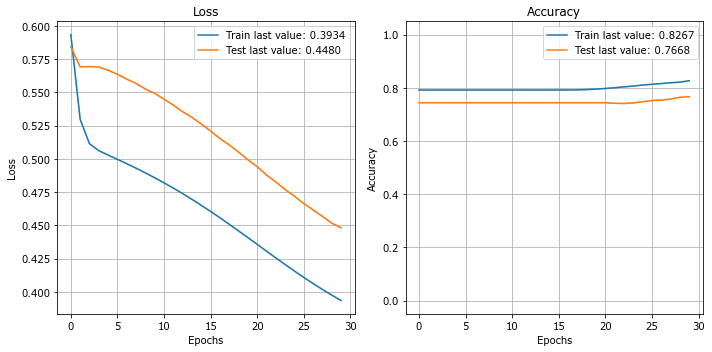

In [67]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

##  Model 2-2: CNN or LSTM with pre-trained word embeddings

Please try one more model (CNN or LSTM) with pre-trained word embeddings in here:

In [70]:
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding, MaxPooling1D
from keras.models import Model
from keras.models import Sequential

# your code goes here
VOCAB_SIZE = 32575
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE = 100

#model = Sequential()
Input = Input((128,), dtype='int32')
Embedding = embeddingLayer(Input)
conv1d = Conv1D(filters = 128,kernel_size= 5, activation='relu')(Embedding)
global_max_pooling1d = GlobalAveragePooling1D()(conv1d)
Hidden = Dense(10, activation='relu')(global_max_pooling1d)
Output = Dense(1, activation='sigmoid')(Hidden)
model4 = Model(inputs=[Input], outputs=[Output])
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model4.summary()



Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 128, 300)          120000300 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 128)          192128    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 120,193,729
Trainable params: 193,429
Non-trainable params: 120,000,300
_______________________________________

In [71]:
history = model4.fit(x_train_pad_glove,
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_dev_pad_glove, y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 8s 216ms/step - loss: 0.5565 - accuracy: 0.7911 - val_loss: 0.5186 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 8s 216ms/step - loss: 0.4296 - accuracy: 0.8020 - val_loss: 0.4194 - val_accuracy: 0.8030
Epoch 3/30
35/35 [==============================] - 7s 214ms/step - loss: 0.3555 - accuracy: 0.8504 - val_loss: 0.4022 - val_accuracy: 0.8158
Epoch 4/30
35/35 [==============================] - 8s 225ms/step - loss: 0.3355 - accuracy: 0.8596 - val_loss: 0.3998 - val_accuracy: 0.8158
Epoch 5/30
35/35 [==============================] - 7s 212ms/step - loss: 0.3243 - accuracy: 0.8647 - val_loss: 0.3922 - val_accuracy: 0.8234
Epoch 6/30
35/35 [==============================] - 7s 204ms/step - loss: 0.3127 - accuracy: 0.8688 - val_loss: 0.3930 - val_accuracy: 0.8242
Epoch 7/30
35/35 [==============================] - 7s 203ms/step - loss: 0.3030 - accuracy: 0.8698 - val_loss: 0.3916 - val_accuracy: 0.8257
Epoch 

In [72]:
results = model4.evaluate(x_test_pad_glove, y_test)
print(results)

194/194 [==============================] - 1s 6ms/step - loss: 0.4172 - accuracy: 0.8147
[0.41722357273101807, 0.8147130012512207]


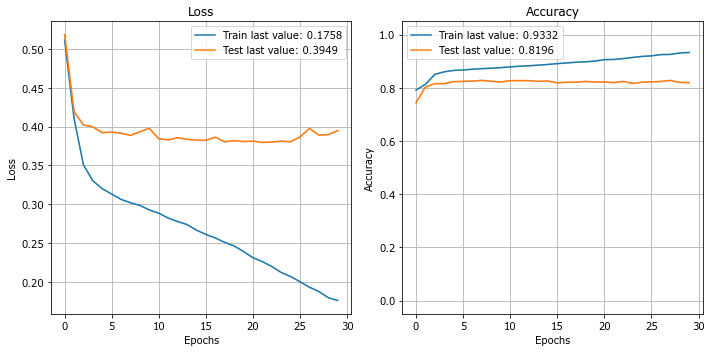

In [73]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

#  Model 3: Model with multiple-input

Model 1 and 2 are copied from lab4. We build new models in this section. 

In models 1 and 2, we combine the topics and tweets to input into the models. In model 3, we separately input these two data into the model and use different layers to analyze topics and tweets. 

In [92]:
# First of all, pad the tweet and topic separately
x_train_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_tweet_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=128)

x_dev_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_test_tweet_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_tweet_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=128)

x_train_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_train_topic_glove,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=16)

x_dev_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_dev_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

x_test_topic_pad_glove = keras.preprocessing.sequence.pad_sequences(x_test_topic_glove,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=16)

## Model 3-1 Neural bag of words model with multiple-input

Model 3-1 needs you to modify the model 2-1 to be compatible with multiple-input.
You could find some tutorial examples from (https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/).

Please print the model summary and visualize it using vis_utils.

In [89]:
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding,concatenate
from keras.models import Model
from keras.models import Sequential


InputTweet = Input((128,), dtype='int32')
InputTopic = Input((16,), dtype='int32')

EmbeddingTweet = embeddingLayer(InputTweet)
global_average_pooling1dTweet = GlobalAveragePooling1D()(EmbeddingTweet)
TweetBranch = Model(inputs=InputTweet, outputs=global_average_pooling1dTweet)

EmbeddingTopic = embeddingLayer(InputTopic)
global_average_pooling1dTopic = GlobalAveragePooling1D()(EmbeddingTopic)
TopicBranch = Model(inputs=InputTopic, outputs=global_average_pooling1dTopic)

combined = concatenate([TweetBranch.output, TopicBranch.output])

Hidden_1 = Dense(16,activation='sigmoid')(combined)
Output = Dense(1, activation='sigmoid')(Hidden_1)
model5 = Model(inputs=[TweetBranch.input, TopicBranch.input], outputs=[Output])  

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model5.summary()



Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_18 (Gl (None, 300)          0           GloVe_Embeddings[14][0]   

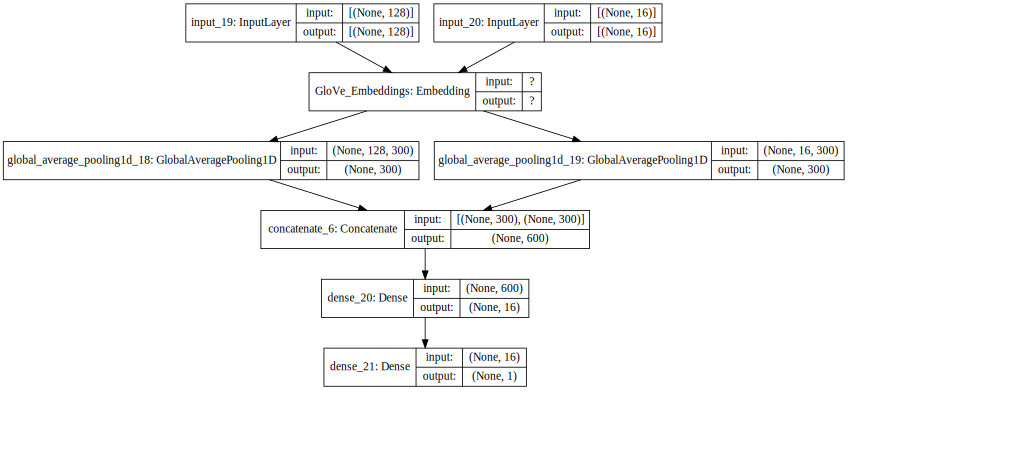

In [90]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model5, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

Train and evaluate your model:

In [95]:
# your code goes here

history = model5.fit([x_train_tweet_pad_glove,x_train_topic_pad_glove],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_tweet_pad_glove,x_dev_topic_pad_glove], y_dev),
                    verbose=1)


Epoch 1/30
35/35 [==============================] - 1s 30ms/step - loss: 0.5146 - accuracy: 0.7917 - val_loss: 0.5625 - val_accuracy: 0.7442
Epoch 2/30
35/35 [==============================] - 1s 26ms/step - loss: 0.4976 - accuracy: 0.7917 - val_loss: 0.5588 - val_accuracy: 0.7442
Epoch 3/30
35/35 [==============================] - 1s 27ms/step - loss: 0.4889 - accuracy: 0.7917 - val_loss: 0.5535 - val_accuracy: 0.7442
Epoch 4/30
35/35 [==============================] - 1s 27ms/step - loss: 0.4814 - accuracy: 0.7917 - val_loss: 0.5463 - val_accuracy: 0.7442
Epoch 5/30
35/35 [==============================] - 1s 26ms/step - loss: 0.4740 - accuracy: 0.7917 - val_loss: 0.5388 - val_accuracy: 0.7442
Epoch 6/30
35/35 [==============================] - 1s 26ms/step - loss: 0.4666 - accuracy: 0.7922 - val_loss: 0.5317 - val_accuracy: 0.7442
Epoch 7/30
35/35 [==============================] - 1s 27ms/step - loss: 0.4594 - accuracy: 0.7969 - val_loss: 0.5243 - val_accuracy: 0.7442
Epoch 8/30
35

In [103]:
results = model5.evaluate([x_test_tweet_pad_glove,x_test_topic_pad_glove], y_test)
print(results)

194/194 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6346
[0.6566269993782043, 0.6345998644828796]


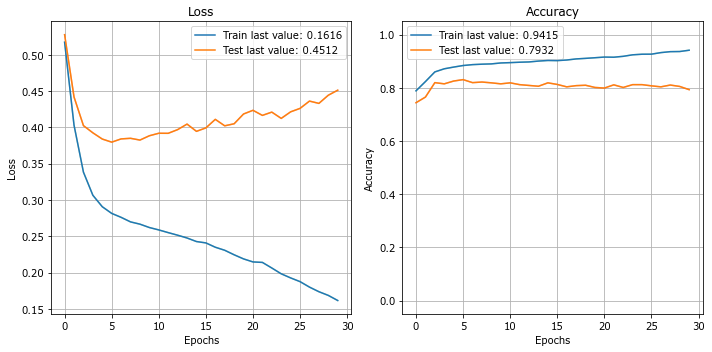

In [104]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

## Model 3-2 CNN or LSTM model with multiple-input

Modify the previous CNN or LSTM model to be compatible with multiple-input, similar to model 3-1. 

In [116]:
# your code goes here

from keras.layers import Input, Embedding, Dense, LSTM
from keras.layers import Input, Lambda, GlobalAveragePooling1D, Dense, Embedding, MaxPooling1D, concatenate
from keras.models import Model
from keras.models import Sequential

# your code goes here
VOCAB_SIZE = 32575
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE = 100


InputTweet = Input((128,), dtype='int32')
InputTopic = Input((16,), dtype='int32')

EmbeddingTweet = embeddingLayer(InputTweet)
conv1dTweet = Conv1D(filters = 128,kernel_size= 9, activation='relu')(EmbeddingTweet)
global_max_pooling1dTweet = GlobalAveragePooling1D()(conv1dTweet)
TweetBranch = Model(inputs=InputTweet, outputs=global_max_pooling1dTweet)

EmbeddingTopic = embeddingLayer(InputTopic)
conv1dTopic = Conv1D(filters = 128,kernel_size= 9, activation='relu')(EmbeddingTopic)
global_max_pooling1dTopic = GlobalAveragePooling1D()(conv1dTopic)
TopicBranch = Model(inputs=InputTopic, outputs=global_max_pooling1dTopic)

combined = concatenate([TweetBranch.output, TopicBranch.output])

Hidden = Dense(10, activation='relu')(combined)
Output = Dense(1, activation='sigmoid')(Hidden)
model6 = Model(inputs=[TweetBranch.input, TopicBranch.input], outputs=[Output])
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

model6.summary()


Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
GloVe_Embeddings (Embedding)    multiple             120000300   input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 120, 128)     345728      GloVe_Embeddings[22][0]   

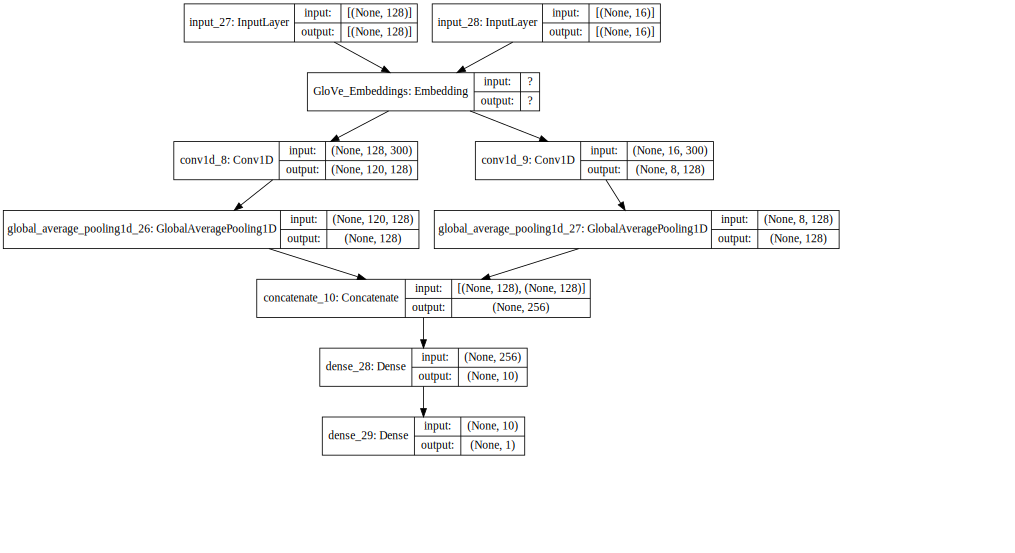

In [117]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model6, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

In [118]:
history = model6.fit([x_train_tweet_pad_glove,x_train_topic_pad_glove],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_tweet_pad_glove,x_dev_topic_pad_glove], y_dev),
                    verbose=1)

Epoch 1/30
35/35 [==============================] - 13s 343ms/step - loss: 0.5526 - accuracy: 0.7594 - val_loss: 0.5105 - val_accuracy: 0.7457
Epoch 2/30
35/35 [==============================] - 12s 342ms/step - loss: 0.3960 - accuracy: 0.8290 - val_loss: 0.4297 - val_accuracy: 0.7781
Epoch 3/30
35/35 [==============================] - 12s 339ms/step - loss: 0.3296 - accuracy: 0.8630 - val_loss: 0.3970 - val_accuracy: 0.8234
Epoch 4/30
35/35 [==============================] - 12s 339ms/step - loss: 0.2988 - accuracy: 0.8740 - val_loss: 0.4018 - val_accuracy: 0.8106
Epoch 5/30
35/35 [==============================] - 12s 339ms/step - loss: 0.2868 - accuracy: 0.8803 - val_loss: 0.3911 - val_accuracy: 0.8196
Epoch 6/30
35/35 [==============================] - 12s 338ms/step - loss: 0.2804 - accuracy: 0.8822 - val_loss: 0.3943 - val_accuracy: 0.8189
Epoch 7/30
35/35 [==============================] - 12s 335ms/step - loss: 0.2658 - accuracy: 0.8908 - val_loss: 0.4009 - val_accuracy: 0.8174

In [119]:
results = model6.evaluate([x_test_tweet_pad_glove,x_test_topic_pad_glove], y_test)
print(results)

194/194 [==============================] - 2s 9ms/step - loss: 0.4993 - accuracy: 0.8123
[0.4992561638355255, 0.8122878074645996]


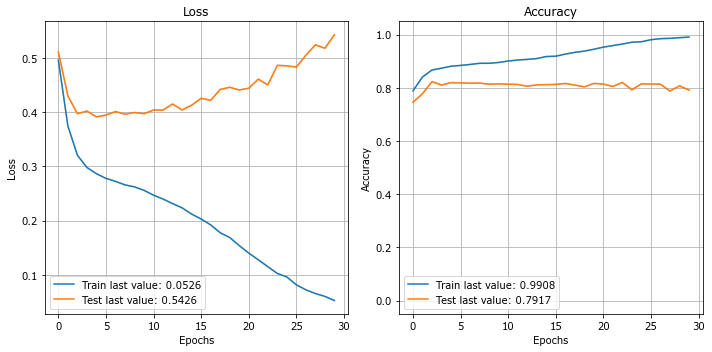

In [120]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()